In [1]:
from centrex_tlf_hamiltonian import states, hamiltonian, transitions
import centrex_tlf_couplings as couplings
import centrex_tlf_lindblad as lindblad
import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({'font.size': 15})

In [3]:
def doppler_shift(velocity, frequency):
    """calculate the doppler shifted frequency
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
    Returns:
        float: doppler shifted frequency in Hz
    """
    return frequency * (1 + velocity / cst.c)


def velocity_to_detuning(velocity, frequency=1.103e15, Γ=2*np.pi*1.56e6):
    """convert velocity to detuning in units of Γ
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
        Γ (float): Γ [2π⋅Hz]
    Returns:
        float: detuning in units of Γ
    """
    return (doppler_shift(velocity, frequency) - frequency) * 2 * np.pi / Γ

In [4]:
trans = [transitions.OpticalTransition(transitions.OpticalTransitionType.Q, J_ground=1, F1=1/2, F=1)]

polarizations = [
    [couplings.polarization_σp]
]

transition_selectors = couplings.generate_transition_selectors(
    trans, polarizations, ground_mains = [
        1*states.CoupledBasisState(
            J=1, F=1, F1=1/2, mF=0, I1=1/2, I2=1/2, Ω=0, P=-1, 
            electronic_state=states.ElectronicState.X
            )
        ],
    excited_mains=[
        1*states.CoupledBasisState(
            J=1, F=1, F1=1/2, mF=1, I1=1/2, I2=1/2, Ω=1, P=+1, 
            electronic_state=states.ElectronicState.B
        )
    ]
)

syspars = lindblad.SystemParameters(nprocs = 7, Γ = hamiltonian.Γ)

In [5]:
v_to_Γ = velocity_to_detuning(1)*hamiltonian.Γ


odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vx*{v_to_Γ}", # detuning of the laser [rad/s]
    
    # laser phase modulation
    ωphase = hamiltonian.Γ,       # laser phase modulation frequency [rad/s]
    β      = 3.8,             # laser phase modulation depth [rad]
    
    Pσp0 = 1,

    # molecules
    z0 = 0,                   # molecule start z position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vx = 0,
)

In [6]:
%%time
obe_system = lindblad.setup_OBE_system_julia_transitions(
    syspars, odepars, trans, transition_selectors, verbose=True, full_output=True, 
    qn_compact= True,
    decay_channels = None,
    E = np.array([0,0,200])
)

INFO:centrex_tlf_lindblad.utils_setup:generate_OBE_system: 1/6 -> Generating the reduced Hamiltonian
INFO:centrex_tlf_lindblad.utils_setup:generate_OBE_system: 2/6 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf_lindblad.utils_setup:generate_OBE_system: 3/6 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf_lindblad.utils_setup:generate_OBE_system: 4/6 -> Generating the collapse matrices
INFO:centrex_tlf_lindblad.utils_setup:generate_OBE_system: 5/6 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations
INFO:centrex_tlf_lindblad.utils_setup:generate_OBE_system: 6/6 -> Generating Julia code representing the system of equations
INFO:centrex_tlf_lindblad.utils_setup:setup_OBE_system_julia: 1/3 -> Generating the preamble
INFO:centrex_tlf_lindblad.utils_setup:setup_OBE_system_julia: 2/3 -> Initializing Julia on 7 cores
INFO:centrex_tlf_lindblad.utils_setup:setup_OBE_system_julia: 3/3 -> Defining the ODE equation and param

Initialized Julia with 7 processes
CPU times: total: 51 s
Wall time: 1min 44s


In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')

,"|B, J = 1, F₁ = 1/2, F = 1>"
states,
"|X, J = 1>",0.999868
"|X, J = 3>",0.000132


In [18]:
obe_system.couplings[0]

CouplingFields(ground_main=|X, J = 1, F₁ = 1/2, F = 1, mF = 0, P = -, Ω = 0>, excited_main=|B, J = 1, F₁ = 1/2, F = 1, mF = 1, P = +, Ω = 1>, main_coupling=4.50e-01+0.00e+00j

In [8]:
obe_system.H_symbolic

Matrix([
[  1.0*δ0 - 133754.097320557,                          0,            0,                0,                           0,                          0,                0,                          0,                          0,                           0,                0,                0,                0,                         0,                          0, -0.518768034673704*Pσp0*Ω0],
[                          0,  1.0*δ0 - 113510.702163696,            0,                0,                           0,                          0,                0,                          0,                          0,                           0,                0,                0,                0,                         0,  0.438645839472849*Pσp0*Ω0,                          0],
[                          0,                          0,       1.0*δ0,                0,                           0,                          0,                0,                          0,                       

In [9]:
qn_select = states.QuantumSelector(J=1, F=1, F1=1/2, mF=0, electronic = states.ElectronicState.X)
idx = qn_select.get_indices(obe_system.QN)
ρ = np.zeros(obe_system.H_symbolic.shape, dtype = complex)
ρ[idx,idx] = 1

In [10]:
problem = lindblad.OBEProblem(odepars, ρ, tspan = (0,200e-6))
config = lindblad.OBEProblemConfig(saveat = 1e-6)

In [11]:
%%time
results = lindblad.do_simulation_single(problem)

CPU times: total: 5.22 s
Wall time: 7.29 s


In [12]:
qn_select_excited = states.QuantumSelector(electronic=states.ElectronicState.B)
indices_excited = qn_select_excited.get_indices(obe_system.QN)

1.29 photons


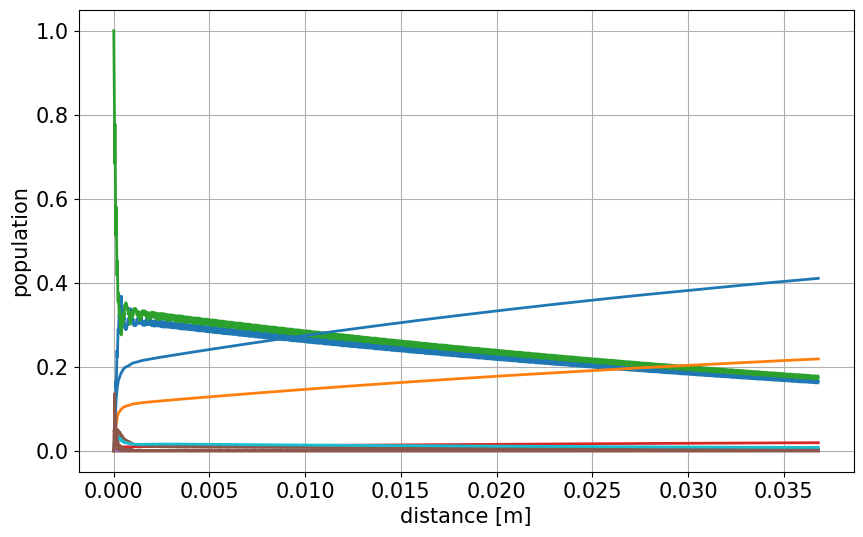

In [13]:
fig, ax = plt.subplots(figsize = (10,6)) 
ax.plot(results.t*odepars.vz, results.y.T, lw = 2)
ax.set_xlabel('distance [m]')
ax.set_ylabel('population')
# ax.legend(fontsize = 14)
ax.grid(True)

nphotons = np.trapz(results.y[indices_excited], x = results.t).sum() * hamiltonian.Γ
print(f"{nphotons:.2f} photons")